<a href="https://colab.research.google.com/github/PSLMssGerd44/Works-/blob/main/Airline_passenger_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicción en series de tiempo
predecir el numero de pasajeros que viajarán en avión en aerolineas internacionales, més a mes (en unidades de 1000). Usaremos para ello un dataset que inicia en enero de 1949 y va hasta diciembre de 1960, es decir 144 observaciones.

In [ ]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2022-09-03 16:33:28--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2022-09-03 16:33:28 (41.3 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



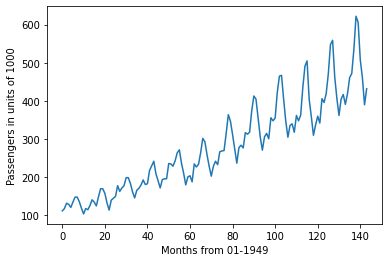

In [ ]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('airline-passengers.csv', usecols=[1])
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.ylabel('Passengers in units of 1000')
plt.xlabel('Months from 01-1949')
plt.show()

In [ ]:
import numpy
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
numpy.random.seed(7) #fijar semilla para que resultados sean reproducibles

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))                     #normalizar datos
dataset = scaler.fit_transform(dataset)

In [ ]:
train_size = int(len(dataset) * 0.65)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

93 51


In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1): #matrices cuyas columnas generan delay respecto a la anterior llegando a un desface del tamaño del look back
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)               # en este caso X=t, Y=t+1 
testX, testY = create_dataset(test, look_back)
print(trainX[:10].T)
print(trainY.T[:10])

[[0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
  0.08494207 0.08494207 0.06177607 0.02895753]]
[0.02702703 0.05405405 0.04826255 0.03281853 0.05984557 0.08494207
 0.08494207 0.06177607 0.02895753 0.        ]


In [ ]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))    # reshape de la forma [samples, time steps, features]
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))      #pequeña red LSTM con 4 celdas y un shape [1, look_back] a la red le entra vector... 
model.add(Dense(1))                                 #...del tamaño de la ventana
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
91/91 - 3s - loss: 0.0307 - 3s/epoch - 29ms/step
Epoch 2/100
91/91 - 0s - loss: 0.0138 - 203ms/epoch - 2ms/step
Epoch 3/100
91/91 - 0s - loss: 0.0110 - 187ms/epoch - 2ms/step
Epoch 4/100
91/91 - 0s - loss: 0.0102 - 185ms/epoch - 2ms/step
Epoch 5/100
91/91 - 0s - loss: 0.0094 - 194ms/epoch - 2ms/step
Epoch 6/100
91/91 - 0s - loss: 0.0087 - 187ms/epoch - 2ms/step
Epoch 7/100
91/91 - 0s - loss: 0.0078 - 188ms/epoch - 2ms/step
Epoch 8/100
91/91 - 0s - loss: 0.0070 - 196ms/epoch - 2ms/step
Epoch 9/100
91/91 - 0s - loss: 0.0061 - 188ms/epoch - 2ms/step
Epoch 10/100
91/91 - 0s - loss: 0.0054 - 219ms/epoch - 2ms/step
Epoch 11/100
91/91 - 0s - loss: 0.0047 - 216ms/epoch - 2ms/step
Epoch 12/100
91/91 - 0s - loss: 0.0042 - 164ms/epoch - 2ms/step
Epoch 13/100
91/91 - 0s - loss: 0.0035 - 159ms/epoch - 2ms/step
Epoch 14/100
91/91 - 0s - loss: 0.0031 - 180ms/epoch - 2ms/step
Epoch 15/100
91/91 - 0s - loss: 0.0027 - 174ms/epoch - 2ms/step
Epoch 16/100
91/91 - 0s - loss: 0.0025 - 162ms/epoc

In [ ]:
#Predicción
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# desescalamiento de la predicción
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calcular error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.25 RMSE
Test Score: 47.13 RMSE


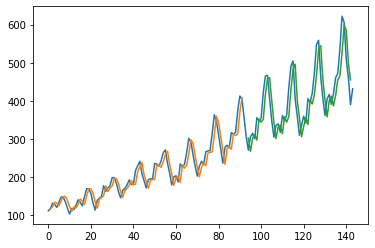

In [ ]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
#se corren los datos predichos para poder visualizarlos
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
look_back = 3 #ventana de 3 pasos de tiempo
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# Creamos y entrenemos el modelo
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# Predicción
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# desescalado
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculo del error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# graficado
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Epoch 1/100
89/89 - 4s - loss: 0.0407 - 4s/epoch - 43ms/step
Epoch 2/100
89/89 - 0s - loss: 0.0181 - 308ms/epoch - 3ms/step
Epoch 3/100
89/89 - 0s - loss: 0.0131 - 232ms/epoch - 3ms/step
Epoch 4/100
89/89 - 0s - loss: 0.0115 - 224ms/epoch - 3ms/step
Epoch 5/100
89/89 - 0s - loss: 0.0105 - 246ms/epoch - 3ms/step
Epoch 6/100
89/89 - 0s - loss: 0.0091 - 267ms/epoch - 3ms/step
Epoch 7/100
89/89 - 0s - loss: 0.0081 - 269ms/epoch - 3ms/step
Epoch 8/100
89/89 - 0s - loss: 0.0071 - 264ms/epoch - 3ms/step
Epoch 9/100
89/89 - 0s - loss: 0.0062 - 308ms/epoch - 3ms/step
Epoch 10/100
89/89 - 0s - loss: 0.0054 - 245ms/epoch - 3ms/step
Epoch 11/100
89/89 - 0s - loss: 0.0048 - 223ms/epoch - 3ms/step
Epoch 12/100
89/89 - 0s - loss: 0.0043 - 283ms/epoch - 3ms/step
Epoch 13/100
89/89 - 0s - loss: 0.0039 - 308ms/epoch - 3ms/step
Epoch 14/100
89/89 - 0s - loss: 0.0036 - 239ms/epoch - 3ms/step
Epoch 15/100
89/89 - 0s - loss: 0.0034 - 202ms/epoch - 2ms/step
Epoch 16/100
89/89 - 0s - loss: 0.0033 - 290ms/epoc

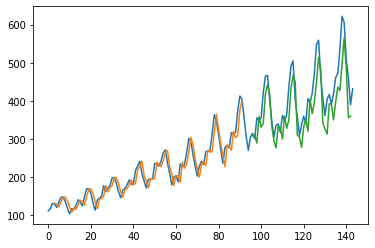

In [ ]:
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
## Pasos de tiempo con reshape diferente

In [ ]:
# el reshape ahora será [samples, features , time steps]
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
print(trainX[:10])

[[[0.01544401]
  [0.02702703]
  [0.05405405]]

 [[0.02702703]
  [0.05405405]
  [0.04826255]]

 [[0.05405405]
  [0.04826255]
  [0.03281853]]

 [[0.04826255]
  [0.03281853]
  [0.05984557]]

 [[0.03281853]
  [0.05984557]
  [0.08494207]]

 [[0.05984557]
  [0.08494207]
  [0.08494207]]

 [[0.08494207]
  [0.08494207]
  [0.06177607]]

 [[0.08494207]
  [0.06177607]
  [0.02895753]]

 [[0.06177607]
  [0.02895753]
  [0.        ]]

 [[0.02895753]
  [0.        ]
  [0.02702703]]]


In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
89/89 - 2s - loss: 0.0534 - 2s/epoch - 21ms/step
Epoch 2/100
89/89 - 0s - loss: 0.0234 - 153ms/epoch - 2ms/step
Epoch 3/100
89/89 - 0s - loss: 0.0175 - 154ms/epoch - 2ms/step
Epoch 4/100
89/89 - 0s - loss: 0.0160 - 179ms/epoch - 2ms/step
Epoch 5/100
89/89 - 0s - loss: 0.0145 - 163ms/epoch - 2ms/step
Epoch 6/100
89/89 - 0s - loss: 0.0131 - 147ms/epoch - 2ms/step
Epoch 7/100
89/89 - 0s - loss: 0.0115 - 144ms/epoch - 2ms/step
Epoch 8/100
89/89 - 0s - loss: 0.0102 - 159ms/epoch - 2ms/step
Epoch 9/100
89/89 - 0s - loss: 0.0088 - 168ms/epoch - 2ms/step
Epoch 10/100
89/89 - 0s - loss: 0.0076 - 151ms/epoch - 2ms/step
Epoch 11/100
89/89 - 0s - loss: 0.0066 - 160ms/epoch - 2ms/step
Epoch 12/100
89/89 - 0s - loss: 0.0056 - 154ms/epoch - 2ms/step
Epoch 13/100
89/89 - 0s - loss: 0.0050 - 147ms/epoch - 2ms/step
Epoch 14/100
89/89 - 0s - loss: 0.0044 - 168ms/epoch - 2ms/step
Epoch 15/100
89/89 - 0s - loss: 0.0040 - 151ms/epoch - 2ms/step
Epoch 16/100
89/89 - 0s - loss: 0.0038 - 180ms/epoc

Train Score: 26.43 RMSE
Test Score: 50.90 RMSE


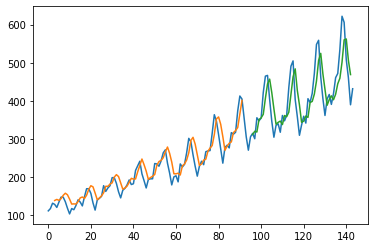

In [ ]:
#hacemos una predicción
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# Reescalemos
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculamos el error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# Graficamos
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()